In [ ]:
"""
This script will fetch all csv files from the specified directory and preprocess them.   
The preprocessing stage will include:   
    - Loop through all the csv files for all subjects and trials.
    - Remove unlabeled data (start and end of the experiment) 
    - Reformatting the labels to be sin and cos of the phase variable.   
    - Prefilter the data to remove noise (e.g. Moving Average)    
    - Splitting the data into windows (by window size and overlap).   
    - Normalizing the input data    
    - Remove unnecessary columns (e.g. timestamp, foot and trunk imu data)   
    - Saving the preprocessed data into a new data npy file based on the inputs provided for the preprocessing stage (test and train).  
"""

In [146]:
import os
import pandas as pd
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, filtfilt
from torch.utils.data import TensorDataset, DataLoader

In [151]:
# Scenario parameter settings
# DATA_PATH = r'dataset'
# DATA_PATH = r'C:\Users\Elad\vscode Projects\Technion\LBIS_project\dataset'
DATA_PATH   = r'C:\Users\Elad\Downloads\dataset\dataset'
validation_subject = 'AB10' # Subject to be used for validation
test_subject = 'AB11'       # Subject to be used for testing
is_filter = True            # True or False decision variable to filter the IMU data before splitting into windows 
filter_type = "causal"      # causal or non-causal - choose causal for RT applications
cutoff = 25                 # cutoff frequency for the filter (Hz)
is_normalize = True         # True or False decision variable to normalize the input data after filtering (before windowing) 
window_size = 200           # Number of samples per window 
overlap = 100               # Number of samples to overlap between windows


In [173]:
def sliding_window_with_label(imu_data: pd.DataFrame, gc_data: pd.DataFrame, window_size=400, overlap=200):
    """ 
    Perform sliding window on IMU data and extract the last value of GC data as label.
    
    Parameters:
    - imu_data: DataFrame with 12 columns (IMU channels)
    - gc_data: DataFrame with 2 columns (labels)
    - window_size: Number of samples per window
    - overlap: Number of overlapping samples

    Returns:
    - X_windows: NumPy array of shape (num_windows, 12, window_size)
    - y_labels: NumPy array of shape (num_windows, 2)
    """
    step_size = window_size - overlap
    X_windows, y_labels = [], []

    for start_idx in range(0, imu_data.shape[0] - window_size + 1, step_size):
        end_idx = start_idx + window_size
        X_windows.append(imu_data.iloc[start_idx:end_idx].values.T)  # (12, window_size)
        y_labels.append(gc_data.iloc[end_idx - 1].values)  # Correctly extract both columns
    
    return np.array(X_windows), np.array(y_labels)

def apply_filter(data, filter_type, cutoff=25, fs=200, order=4):
    b, a = butter(order, cutoff / (fs / 2), btype='low', analog=False)
    return lfilter(b, a, data, axis=0) if filter_type == "causal" else filtfilt(b, a, data, axis=0)

def plot_filtered_imu(original_df, filtered_df, channel_idx=0):
    plt.plot(original_df.iloc[1:500, channel_idx], label="Original", alpha=0.6)
    plt.plot(filtered_df.iloc[1:500, channel_idx], label="Filtered", linestyle="--")
    plt.legend()
    plt.xlabel("Samples")
    plt.ylabel("Amplitude")
    plt.title(f"IMU Channel {original_df.columns[channel_idx]} Before & After Filtering")
    plt.show()

def is_validation_subject(subject_id):
    return subject_id == validation_subject

def is_test_subject(subject_id):
    return subject_id == test_subject

def calc_phase_from_label(label):
    c = label[0]
    s = label[1]
    atan = np.arctan2(s, c) if np.arctan2(s, c) >= 0 else np.arctan2(s, c) + 2 * np.pi
    return atan * 100 / (2 * np.pi)

In [180]:
if is_normalize:
    # Calc the global mean and std for normalization (only on train data to avoid data leakage)
    # Loop through all the csv files for all subjects and trials in the test folders
    all_train_data = np.zeros((0, 12))
    for subject in os.listdir(DATA_PATH):
        # Skip validation and test subjects
        if is_validation_subject(subject) or is_test_subject(subject):
            continue
        # access all csv files in the treadmill folder of the subject
        for file in os.listdir(os.path.join(DATA_PATH,  subject, 'treadmill', 'imu')):
            # read the imu csv file
            if file.endswith('.csv'):
                imu_df = pd.read_csv(os.path.join(DATA_PATH, subject, 'treadmill', 'imu', file))

                # remove unnecessary columns
                imu_df = imu_df.drop(columns=['Header','foot_Accel_X', 'foot_Accel_Y', 'foot_Accel_Z', 'foot_Gyro_X', 'foot_Gyro_Y', 'foot_Gyro_Z', 'trunk_Accel_X', 'trunk_Accel_Y', 'trunk_Accel_Z', 'trunk_Gyro_X', 'trunk_Gyro_Y', 'trunk_Gyro_Z'])
                
                # Apply a filter to the IMU data (choose between a causal and non-causal filter i.e. with phase or zero phase lag filters)
                # filter_type = "causal" # or "non-causal" - defined in the scenario parameters settings section
                filtered_df = pd.DataFrame(apply_filter(imu_df.values, filter_type=filter_type, cutoff=25, order=4), columns=imu_df.columns) if is_filter else imu_df
                
                all_train_data = np.vstack((all_train_data, filtered_df.values))

    mean_train = np.mean(all_train_data, axis=0)
    std_train = np.std(all_train_data, axis=0)
    # print((all_train_data.shape))
    # print(mean_train)
    # print(std_train)

In [ ]:
# Preallocate a multidimensional array to store all the data for all trials and all subjects in test/train npy file
X_data = np.empty((0, 12, window_size))
y_data = np.empty((0, 2))
X_validation_data = np.empty((0, 12, window_size))
y_validation_data = np.empty((0, 2))
X_test_data = np.empty((0, 12, window_size))
y_test_data = np.empty((0, 2))

# access all subject folders
for subject in os.listdir(DATA_PATH):
    # access all csv files in the treadmill folder of the subject
    for file in os.listdir(os.path.join(DATA_PATH,  subject, 'treadmill', 'imu')):
        # read the imu csv file
        if file.endswith('.csv'):
            imu_df = pd.read_csv(os.path.join(DATA_PATH, subject, 'treadmill', 'imu', file))
            gc_df = pd.read_csv(os.path.join(DATA_PATH, subject, 'treadmill', 'gcRight', file))

            # remove unnecessary columns
            gc_df = gc_df.drop(columns=["ToeOff"])
            imu_df = imu_df.drop(columns=['foot_Accel_X', 'foot_Accel_Y', 'foot_Accel_Z', 'foot_Gyro_X', 'foot_Gyro_Y', 'foot_Gyro_Z', 'trunk_Accel_X', 'trunk_Accel_Y', 'trunk_Accel_Z', 'trunk_Gyro_X', 'trunk_Gyro_Y', 'trunk_Gyro_Z'])

            # remove the first and last samples that have no proper label defined (until the first Heel Strike occurance + after the last Toe Off occurance)
            gc_df = gc_df.loc[gc_df.index[gc_df["HeelStrike"].gt(0)].min() : gc_df.index[gc_df["HeelStrike"] == 100].max()]
            imu_df = imu_df[imu_df["Header"].isin(gc_df["Header"])] # remove the rows that are not in the gc data

            # Apply the cosine and sine functions to the HeelStrike column
            gc_df['cos_gait_phase'] = np.cos(gc_df['HeelStrike'] * 2 * np.pi / 100)
            gc_df['sin_gait_phase'] = np.sin(gc_df['HeelStrike'] * 2 * np.pi / 100)
            
            # remove header and other columns
            gc_df.drop(columns=["Header","HeelStrike"], inplace=True)
            imu_df.drop(columns=['Header'], inplace=True)

            gc_df.reset_index(drop=True, inplace=True)
            imu_df.reset_index(drop=True, inplace=True)

            # Apply a filter to the IMU data (choose between a causal and non-causal filter i.e. with phase or zero phase lag filters)
            # filter_type = "causal" # or "non-causal" - defined in the scenario parameters settings section
            filtered_df = pd.DataFrame(apply_filter(imu_df.values, filter_type=filter_type, cutoff=25, order=4), columns=imu_df.columns) if is_filter else imu_df

            # Normalize the input data (is_normalize = True or False)
            filtered_df = (filtered_df - mean_train) / std_train if is_normalize else filtered_df

            # Split the data into windows (by window size and overlap)
            X_windows, y_labels = sliding_window_with_label(filtered_df, gc_df, window_size=window_size, overlap=overlap)
            
            # Concatenate the data to the multidimensional array according to the train / test / validation
            if is_validation_subject(subject):
                X_validation_data = np.concatenate((X_validation_data, X_windows), axis=0)
                y_validation_data = np.concatenate((y_validation_data, y_labels), axis=0)
            elif is_test_subject(subject):                
                X_test_data = np.concatenate((X_test_data, X_windows), axis=0)
                y_test_data = np.concatenate((y_test_data, y_labels), axis=0)
            else:    
                X_data = np.concatenate((X_data, X_windows), axis=0)
                y_data = np.concatenate((y_data, y_labels), axis=0)
            
    # print(f"The shape of X_windows is: {X_windows.shape}")
    # print(f"The shape of y_labels is: {y_labels.shape}")
    # print(f"The first window of X_windows is: {X_windows[0]}")
    # print(f"The first label of y_labels is: {y_labels[0]}")
    # plot_filtered_imu(imu_df, filtered_df, channel_idx=0)  # Change channel_idx to plot different channels
    # print(gc_df.head())
    # print(imu_df.head())


In [ ]:
print(f"The shape of X_data is: {X_data.shape}")
print(f"The shape of y_data is: {y_data.shape}")
print(f"The shape of X_validation_data is: {X_validation_data.shape}")
print(f"The shape of y_validation_data is: {y_validation_data.shape}")
print(f"The shape of X_test_data is: {X_test_data.shape}")
print(f"The shape of y_test_data is: {y_test_data.shape}")

In [83]:
# save the testing and training data into npy files
np.save('X_train.npy', X_data)
np.save('y_train.npy', y_data)
np.save('X_test.npy', X_test_data)
np.save('y_test.npy', y_test_data)
np.save('X_validation.npy', X_validation_data)
np.save('y_validation.npy', y_validation_data)

# Plottings

C:\Users\Elad\AppData\Local\Temp\ipykernel_13384\2836788697.py:31: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


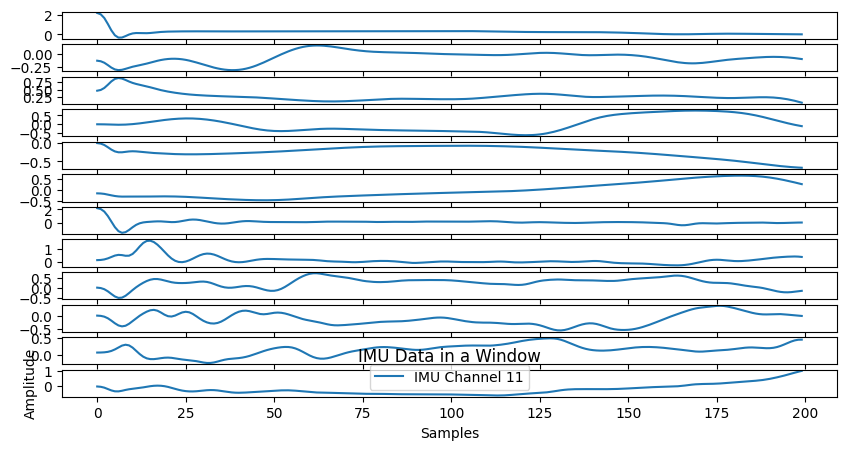

55.17241379310339


In [177]:
# Show a typical window of the 12 channels of IMU data and print its corresponding label of gait phase (cosine and sine)
plt.figure(figsize=(10, 5))
plt.subplot(12, 1, 1)
plt.plot(X_data[0, 0, :], label="IMU Channel 0")
plt.subplot(12, 1, 2)
plt.plot(X_data[0, 1, :], label="IMU Channel 1")
plt.subplot(12, 1, 3)
plt.plot(X_data[0, 2, :], label="IMU Channel 2")
plt.subplot(12, 1, 4)
plt.plot(X_data[0, 3, :], label="IMU Channel 3")
plt.subplot(12, 1, 5)
plt.plot(X_data[0, 4, :], label="IMU Channel 4")
plt.subplot(12, 1, 6)
plt.plot(X_data[0, 5, :], label="IMU Channel 5")
plt.subplot(12, 1, 7)
plt.plot(X_data[0, 6, :], label="IMU Channel 6")
plt.subplot(12, 1, 8)
plt.plot(X_data[0, 7, :], label="IMU Channel 7")
plt.subplot(12, 1, 9)
plt.plot(X_data[0, 8, :], label="IMU Channel 8")
plt.subplot(12, 1, 10)
plt.plot(X_data[0, 9, :], label="IMU Channel 9")
plt.subplot(12, 1, 11)
plt.plot(X_data[0, 10, :], label="IMU Channel 10")
plt.subplot(12, 1, 12)
plt.plot(X_data[0, 11, :], label="IMU Channel 11")
plt.legend()
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.title("IMU Data in a Window")
plt.tight_layout()
plt.show()

# calc the gait phase label of the first window using atan2
print(calc_phase_from_label(y_data[3]))